In [7]:
!pip -q install insightface onnxruntime-gpu opencv-python-headless tqdm pandas numpy matplotlib
!pip -q install glasses-detector


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 2.2 MB/s eta 0:00:00


In [8]:
import os, time
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm

DATA_ROOT = "/kaggle/input/meglass/MeGlass_ori"
assert os.path.exists(DATA_ROOT), "Path not found. Check Kaggle dataset mount."

all_imgs = [os.path.join(DATA_ROOT, f) for f in os.listdir(DATA_ROOT) if f.lower().endswith(".jpg")]
print("Total JPG images:", len(all_imgs))
print("Example:", all_imgs[0])


Total JPG images: 47917
Example: /kaggle/input/meglass/MeGlass_ori/52422450@N00_identity_1@3236065352_6.jpg


In [9]:
#Face recognition pipeline (InsightFace)
from insightface.app import FaceAnalysis

# Baseline real-time setting
DET_SIZE = (640, 640)

app = FaceAnalysis(name="buffalo_l", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
app.prepare(ctx_id=0, det_size=DET_SIZE)

print("InsightFace ready with det_size:", DET_SIZE)



download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:07<00:00, 38632.61KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

In [10]:
#Eyeglasses attribute inference (label-free)
# glasses-detector provides pretrained models for glasses classification/detection/segmentation
# We'll use its classifier interface (API may vary slightly across versions).
#Setup glasses detector
from glasses_detector import GlassesClassifier

clf = GlassesClassifier()  # loads pretrained weights
print("Glasses classifier loaded.")


Downloading: "https://github.com/mantasu/glasses-detector/releases/download/v1.0.0/classification_anyglasses_shufflenet_v2_x1_0.pth" to /root/.cache/torch/hub/checkpoints/classification_anyglasses_shufflenet_v2_x1_0.pth


100%|██████████| 4.96M/4.96M [00:00<00:00, 9.10MB/s]

Glasses classifier loaded.


In [12]:
#Face crop + eyeglasses inference
def crop_primary_face(img_bgr, faces):
    # choose the largest detected face
    if len(faces) == 0:
        return None
    best = max(faces, key=lambda f: (f.bbox[2]-f.bbox[0])*(f.bbox[3]-f.bbox[1]))
    x1, y1, x2, y2 = best.bbox.astype(int)
    h, w = img_bgr.shape[:2]
    x1, y1 = max(0,x1), max(0,y1)
    x2, y2 = min(w-1,x2), min(h-1,y2)
    if x2 <= x1 or y2 <= y1:
        return None
    face = img_bgr[y1:y2, x1:x2]
    return face

def infer_glasses(face_bgr):
    """
    Returns: (label, confidence)
    label: 1 = glasses, 0 = no-glasses
    """
    # classifier expects RGB in many libs; we convert safely
    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)

    # glasses-detector classifier typically outputs probabilities per class.
    # We'll handle both dict and tuple outputs robustly.
    out = clf.predict(face_rgb)

    # Try common output formats:
    # - dict: {"glasses": p1, "no_glasses": p0} or similar
    # - tuple/list: (label, prob) or (probs array)
    if isinstance(out, dict):
        # pick the two-class case
        keys = [k.lower() for k in out.keys()]
        if "glasses" in keys:
            p_g = out[list(out.keys())[keys.index("glasses")]]
            p_ng = out[list(out.keys())[keys.index("no_glasses")]] if "no_glasses" in keys else 1 - p_g
        else:
            # fallback: take max class
            items = list(out.items())
            kmax, pmax = max(items, key=lambda kv: kv[1])
            label = 1 if "glass" in kmax.lower() else 0
            return label, float(pmax)
        label = 1 if p_g >= p_ng else 0
        conf = float(max(p_g, p_ng))
        return label, conf

    if isinstance(out, (list, tuple)) and len(out) == 2 and isinstance(out[1], (float, int)):
        return int(out[0]), float(out[1])

    # If it's a numpy array of probs:
    if hasattr(out, "shape"):
        probs = np.asarray(out).ravel()
        label = int(np.argmax(probs))
        conf = float(np.max(probs))
        # assume index 1 = glasses in 2-class model; if reversed, you'll detect it in sanity check
        return label, conf

    raise RuntimeError(f"Unknown classifier output format: {type(out)}")


In [14]:
#Label-free cohort building
import os, shutil
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

SEED = 42
rng = np.random.default_rng(SEED)

DATA_ROOT = "/kaggle/input/meglass/MeGlass_ori"
all_imgs = [os.path.join(DATA_ROOT, f) for f in os.listdir(DATA_ROOT) if f.lower().endswith(".jpg")]

# scan subset first
MAX_SCAN = 20000
scan_list = all_imgs.copy()
rng.shuffle(scan_list)
scan_list = scan_list[:min(MAX_SCAN, len(scan_list))]

# temp dir for crops
CROP_DIR = "/kaggle/working/face_crops"
if os.path.exists(CROP_DIR):
    shutil.rmtree(CROP_DIR)
os.makedirs(CROP_DIR, exist_ok=True)

MIN_FACE_SIZE = 80

def crop_primary_face(img_bgr, faces):
    if len(faces) == 0:
        return None
    best = max(faces, key=lambda f: (f.bbox[2]-f.bbox[0])*(f.bbox[3]-f.bbox[1]))
    x1, y1, x2, y2 = best.bbox.astype(int)
    h, w = img_bgr.shape[:2]
    x1, y1 = max(0,x1), max(0,y1)
    x2, y2 = min(w-1,x2), min(h-1,y2)
    if x2 <= x1 or y2 <= y1:
        return None
    face = img_bgr[y1:y2, x1:x2]
    return face

crop_rows = []
saved = 0

for p in tqdm(scan_list):
    img = cv2.imread(p)
    if img is None:
        continue

    faces = app.get(img)  # InsightFace detector
    face_crop = crop_primary_face(img, faces)
    if face_crop is None:
        continue

    if min(face_crop.shape[:2]) < MIN_FACE_SIZE:
        continue

    # save crop with stable filename
    out_name = f"crop_{saved:06d}.jpg"
    out_path = os.path.join(CROP_DIR, out_name)
    cv2.imwrite(out_path, face_crop)

    crop_rows.append({"orig_path": p, "crop_path": out_path})
    saved += 1

df_crops = pd.DataFrame(crop_rows)
print("Saved face crops:", len(df_crops))
df_crops.head()


  0%|          | 0/20000 [00:00<?, ?it/s]

Saved face crops: 18149


,orig_path,crop_path
0,/kaggle/input/meglass/MeGlass_ori/51368783@N00...,/kaggle/working/face_crops/crop_000000.jpg
1,/kaggle/input/meglass/MeGlass_ori/96841989@N00...,/kaggle/working/face_crops/crop_000001.jpg
2,/kaggle/input/meglass/MeGlass_ori/10081417@N00...,/kaggle/working/face_crops/crop_000002.jpg
3,/kaggle/input/meglass/MeGlass_ori/40286210@N00...,/kaggle/working/face_crops/crop_000003.jpg
4,/kaggle/input/meglass/MeGlass_ori/16446760@N00...,/kaggle/working/face_crops/crop_000004.jpg


In [20]:
!glasses-detector --help | head -n 120


usage: Glasses Detector [-h] -i path/to/dir/or/file [-o path/to/dir/or/file]
                        [-e <ext>] [-f <format>] [-t <task-name>]
                        [-s <model-size>] [-b <batch-size>] [-p <pbar-desc>]
                        [-w path/to/weights.pth] [-d <device>]

Classification, detection, and segmentation of glasses in images.

options:
  -h, --help            show this help message and exit
  -i path/to/dir/or/file, --input path/to/dir/or/file
                        Path to the input image or the directory with images.
  -o path/to/dir/or/file, --output path/to/dir/or/file
                        Path to the output file or the directory. If not
                        provided, then, if input is a file, the prediction
                        will be printed (or shown if it is an image),
                        otherwise, if input is a directory, the predictions
                        will be written to a directory with the same name with
                        

In [21]:
!glasses-detector --help | grep -i "kind" -n | head -n 50


42:                        The kind of task the model should perform. One of


In [23]:
OUT_DIR = "/kaggle/working/gd_out"
!rm -rf "$OUT_DIR"
!mkdir -p "$OUT_DIR"

!glasses-detector -i "$CROP_DIR" -o "$OUT_DIR" -t anyglasses-classifier -s small


usage: Glasses Detector [-h] -i path/to/dir/or/file [-o path/to/dir/or/file]
                        [-e <ext>] [-f <format>] [-t <task-name>]
                        [-s <model-size>] [-b <batch-size>] [-p <pbar-desc>]
                        [-w path/to/weights.pth] [-d <device>]
Glasses Detector: error: argument -t/--task: invalid choice: 'anyglasses-classifier' (choose from classification, classification:anyglasses, classification:sunglasses, classification:eyeglasses, classification:shadows, detection, detection:eyes, detection:solo, detection:worn, segmentation, segmentation:frames, segmentation:full, segmentation:legs, segmentation:lenses, segmentation:shadows, segmentation:smart)


In [25]:
!ls -R /kaggle/working/gd_out


/kaggle/working/gd_out:


In [27]:
OUT_DIR = "/kaggle/working/gd_out"

# show everything that exists
!echo "== OUT_DIR tree ==" 
!ls -lah "$OUT_DIR"
!echo
!echo "== recursive listing (first 200 lines) =="
!ls -R "$OUT_DIR" | head -n 200


== OUT_DIR tree ==
total 8.0K
drwxr-xr-x 2 root root 4.0K Jan 12 00:36 .
drwxr-xr-x 5 root root 4.0K Jan 12 00:36 ..

== recursive listing (first 200 lines) ==
/kaggle/working/gd_out:


In [28]:
OUT_CSV = "/kaggle/working/glasses_preds.csv"

# Important: output is a FILE (.csv), not a directory.
# Important: task is classification:anyglasses (default per docs), size small (weights available)
!glasses-detector -i "$CROP_DIR" -o "$OUT_CSV" -t "classification:anyglasses" -s small -f proba


Downloading: "https://github.com/mantasu/glasses-detector/releases/download/v1.0.0/classification_anyglasses_tinyclsnet_v1.pth" to /root/.cache/torch/hub/checkpoints/classification_anyglasses_tinyclsnet_v1.pth
100%|█████████████████████████████████████████| 122k/122k [00:00<00:00, 650kB/s]
Processing: 100%|██████████████████████| 18149/18149 [02:23<00:00, 126.62file/s]


In [29]:
import os, pandas as pd

print("CSV exists:", os.path.exists("/kaggle/working/glasses_preds.csv"))
preds = pd.read_csv("/kaggle/working/glasses_preds.csv")
print("Columns:", preds.columns.tolist())
preds.head()


CSV exists: True
Columns: ['crop_004435.jpg', '0.45941266417503357']


,crop_004435.jpg,0.45941266417503357
0,crop_006553.jpg,0.000046
1,crop_001994.jpg,0.000028
2,crop_005715.jpg,0.946020
3,crop_012864.jpg,0.836092
4,crop_011280.jpg,0.000629


In [31]:
import pandas as pd
import os
import numpy as np

OUT_CSV = "/kaggle/working/glasses_preds.csv"

preds = pd.read_csv(OUT_CSV, header=None, names=["crop_file", "score"])
print(preds.head())
print("Rows:", len(preds))
print(preds["score"].describe())


         crop_file     score
0  crop_004435.jpg  0.459413
1  crop_006553.jpg  0.000046
2  crop_001994.jpg  0.000028
3  crop_005715.jpg  0.946020
4  crop_012864.jpg  0.836092
Rows: 18149
count    1.814900e+04
mean     3.183762e-01
std      3.992660e-01
min      2.114917e-08
25%      1.088421e-03
50%      3.834856e-02
75%      7.842783e-01
max      9.999256e-01
Name: score, dtype: float64


In [34]:
#Threshold + merge
# choose a threshold
TH = 0.50  # start with 0.50 (we can tune)

preds["glasses"] = (preds["score"] >= TH).astype(int)

# df_crops already has crop_path and orig_path
df_crops["crop_file"] = df_crops["crop_path"].apply(os.path.basename)

df_attr = df_crops.merge(preds[["crop_file","score","glasses"]], on="crop_file", how="inner")

print("Merged:", len(df_attr))
print(df_attr["glasses"].value_counts())
df_attr.head()


Merged: 18149
glasses
0    12311
1     5838
Name: count, dtype: int64


,orig_path,crop_path,crop_file,score,glasses
0,/kaggle/input/meglass/MeGlass_ori/51368783@N00...,/kaggle/working/face_crops/crop_000000.jpg,crop_000000.jpg,0.988419,1
1,/kaggle/input/meglass/MeGlass_ori/96841989@N00...,/kaggle/working/face_crops/crop_000001.jpg,crop_000001.jpg,0.889789,1
2,/kaggle/input/meglass/MeGlass_ori/10081417@N00...,/kaggle/working/face_crops/crop_000002.jpg,crop_000002.jpg,0.044131,0
3,/kaggle/input/meglass/MeGlass_ori/40286210@N00...,/kaggle/working/face_crops/crop_000003.jpg,crop_000003.jpg,0.000007,0
4,/kaggle/input/meglass/MeGlass_ori/16446760@N00...,/kaggle/working/face_crops/crop_000004.jpg,crop_000004.jpg,0.671037,1


In [35]:
#High-confidence cohorts
CONF = 0.90  # confidence filter
df_hc = df_attr[(df_attr["score"] >= CONF) | (df_attr["score"] <= 1-CONF)].copy()

print("High-confidence kept:", len(df_hc))
print(df_hc["glasses"].value_counts())


High-confidence kept: 13542
glasses
0    10185
1     3357
Name: count, dtype: int64


In [37]:
#Sample 1000 eyeglasses + 1000 non-eyeglasses
SEED = 42
N_PER_GROUP = 1000

df_g = df_hc[df_hc["glasses"]==1]
df_n = df_hc[df_hc["glasses"]==0]

print("Available glasses:", len(df_g), "no-glasses:", len(df_n))

assert len(df_g) >= N_PER_GROUP and len(df_n) >= N_PER_GROUP, (
    "Not enough high-confidence samples. Lower CONF (e.g., 0.85) or increase MAX_SCAN."
)

df_bal = pd.concat([
    df_g.sample(N_PER_GROUP, random_state=SEED),
    df_n.sample(N_PER_GROUP, random_state=SEED),
], ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)

# final set for latency experiment
df_bal = df_bal.rename(columns={"orig_path":"path"})
print(df_bal["glasses"].value_counts())
df_bal.head()


Available glasses: 3357 no-glasses: 10185
glasses
0    1000
1    1000
Name: count, dtype: int64


,path,crop_path,crop_file,score,glasses
0,/kaggle/input/meglass/MeGlass_ori/24133132@N04...,/kaggle/working/face_crops/crop_005595.jpg,crop_005595.jpg,0.001448,0
1,/kaggle/input/meglass/MeGlass_ori/98679389@N00...,/kaggle/working/face_crops/crop_011708.jpg,crop_011708.jpg,0.944852,1
2,/kaggle/input/meglass/MeGlass_ori/85772145@N00...,/kaggle/working/face_crops/crop_002777.jpg,crop_002777.jpg,0.002165,0
3,/kaggle/input/meglass/MeGlass_ori/25045012@N07...,/kaggle/working/face_crops/crop_014168.jpg,crop_014168.jpg,0.907228,1
4,/kaggle/input/meglass/MeGlass_ori/28196170@N02...,/kaggle/working/face_crops/crop_015930.jpg,crop_015930.jpg,0.095365,0


In [38]:
print(df_bal["glasses"].value_counts())
print(df_bal[["score"]].describe())


glasses
0    1000
1    1000
Name: count, dtype: int64
              score
count  2.000000e+03
mean   4.870245e-01
std    4.764642e-01
min    1.207772e-07
25%    1.672709e-03
50%    4.982555e-01
75%    9.683778e-01
max    9.999256e-01


In [39]:
#Latency Measurement (Rigorous & Reproducible)
#warm up
import cv2, time
from tqdm.auto import tqdm

# Warm-up to stabilize GPU / kernels
for p in df_bal.head(30)["path"]:
    img = cv2.imread(p)
    _ = app.get(img)

print("Warm-up completed.")


Warm-up completed.


In [40]:
#Robust latency measurement (K repeated runs)
import numpy as np
import pandas as pd

def trimmed_mean(arr, trim=0.2):
    arr = np.sort(np.asarray(arr))
    k = int(len(arr) * trim)
    if len(arr) - 2*k <= 0:
        return float(arr.mean())
    return float(arr[k:len(arr)-k].mean())

def measure_latency(df, K=5):
    records = []
    for row in tqdm(df.itertuples(index=False), total=len(df)):
        img = cv2.imread(row.path)

        lats = []
        faces_last = None
        for _ in range(K):
            t0 = time.perf_counter()
            faces_last = app.get(img)
            t1 = time.perf_counter()
            lats.append((t1 - t0) * 1000)

        n_faces = len(faces_last) if faces_last is not None else 0
        det_score = (
            float(getattr(faces_last[0], "det_score", np.nan))
            if n_faces > 0 else np.nan
        )

        records.append({
            "path": row.path,
            "glasses": int(row.glasses),
            "lat_trim_ms": trimmed_mean(lats, trim=0.2),
            "lat_p95_ms": float(np.percentile(lats, 95)),
            "n_faces": n_faces,
            "det_score": det_score,
            "attr_score": float(row.score),
        })
    return pd.DataFrame(records)

df_lat = measure_latency(df_bal, K=5)
df_lat.head()


  0%|          | 0/2000 [00:00<?, ?it/s]

,path,glasses,lat_trim_ms,lat_p95_ms,n_faces,det_score,attr_score
0,/kaggle/input/meglass/MeGlass_ori/24133132@N04...,0,31.609317,33.170164,1,0.887747,0.001448
1,/kaggle/input/meglass/MeGlass_ori/98679389@N00...,1,30.712566,32.061102,1,0.810409,0.944852
2,/kaggle/input/meglass/MeGlass_ori/85772145@N00...,0,29.580962,30.161001,1,0.834965,0.002165
3,/kaggle/input/meglass/MeGlass_ori/25045012@N07...,1,30.883946,31.503068,1,0.867405,0.907228
4,/kaggle/input/meglass/MeGlass_ori/28196170@N02...,0,48.928198,49.354776,2,0.817961,0.095365


In [41]:
#Fairness metrics (mean, p95, p99)
#Latency Fairness Metrics (Mean + Tail)
#This is where novelty starts
def pct(x, p):
    return float(np.percentile(np.asarray(x), p))

def latency_report(df):
    rows = []
    for lab, name in [(1,"Eyeglasses"), (0,"No-Eyeglasses")]:
        x = df[df["glasses"]==lab]["lat_trim_ms"].values
        rows.append({
            "group": name,
            "n": len(x),
            "mean_ms": x.mean(),
            "median_ms": np.median(x),
            "p95_ms": pct(x,95),
            "p99_ms": pct(x,99),
        })
    rep = pd.DataFrame(rows)

    g = rep[rep["group"]=="Eyeglasses"].iloc[0]
    n = rep[rep["group"]=="No-Eyeglasses"].iloc[0]

    fairness = {
        "mean_gap_ms": g["mean_ms"] - n["mean_ms"],
        "mean_ratio": g["mean_ms"] / n["mean_ms"],
        "p95_gap_ms": g["p95_ms"] - n["p95_ms"],
        "p99_gap_ms": g["p99_ms"] - n["p99_ms"],
    }
    return rep, fairness

rep, fairness = latency_report(df_lat)
rep, fairness


(           group     n    mean_ms  median_ms     p95_ms     p99_ms
 0     Eyeglasses  1000  36.190637  30.859949  51.263188  87.003824
 1  No-Eyeglasses  1000  35.682493  30.815265  50.752241  69.121282,
 {'mean_gap_ms': np.float64(0.5081433719851631),
  'mean_ratio': np.float64(1.0142406913549404),
  'p95_gap_ms': np.float64(0.5109471501631049),
  'p99_gap_ms': np.float64(17.882541609551495)})

In [42]:
#Statistical Evidence
#Effect sizes
def cohens_d(a, b):
    a, b = np.asarray(a), np.asarray(b)
    sp = np.sqrt(((a.var(ddof=1)*(len(a)-1)) + (b.var(ddof=1)*(len(b)-1))) / (len(a)+len(b)-2))
    return (a.mean() - b.mean()) / sp

def cliffs_delta(a, b):
    a, b = np.asarray(a), np.asarray(b)
    return (np.sum(a[:,None] > b) - np.sum(a[:,None] < b)) / (len(a)*len(b))

g = df_lat[df_lat["glasses"]==1]["lat_trim_ms"]
n = df_lat[df_lat["glasses"]==0]["lat_trim_ms"]

print("Cohen’s d:", cohens_d(g, n))
print("Cliff’s delta:", cliffs_delta(g, n))


Cohen’s d: 0.040919269842809664
Cliff’s delta: 0.032832


In [43]:
#Permutation test (distribution-free)
def permutation_test(a, b, n_perm=3000, seed=42):
    rng = np.random.default_rng(seed)
    obs = a.mean() - b.mean()
    pooled = np.concatenate([a,b])
    cnt = 0
    for _ in range(n_perm):
        rng.shuffle(pooled)
        if abs(pooled[:len(a)].mean() - pooled[len(a):].mean()) >= abs(obs):
            cnt += 1
    return obs, (cnt+1)/(n_perm+1)

obs, p = permutation_test(g.values, n.values)
print("Observed mean diff (ms):", obs)
print("Permutation p-value:", p)


Observed mean diff (ms): 0.5081433719851631
Permutation p-value: 0.3598800399866711


In [44]:
#Bootstrap confidence interval
def bootstrap_ci(a, b, n_boot=3000, seed=7):
    rng = np.random.default_rng(seed)
    diffs = []
    for _ in range(n_boot):
        diffs.append(
            rng.choice(a, len(a), True).mean() -
            rng.choice(b, len(b), True).mean()
        )
    return np.percentile(diffs, [2.5, 97.5])

print("95% CI (ms):", bootstrap_ci(g.values, n.values))


95% CI (ms): [-0.56742679  1.59402034]


In [45]:
#Controlled Analysis (Responsible AI)
#Regression with controls
from sklearn.linear_model import LinearRegression

tmp = df_lat.dropna(subset=["lat_trim_ms","det_score"]).copy()
tmp["is_glasses"] = (tmp["glasses"]==1).astype(int)

X = tmp[["is_glasses","n_faces","det_score","attr_score"]].values
y = tmp["lat_trim_ms"].values

lr = LinearRegression().fit(X, y)

print("Coefficients [is_glasses, n_faces, det_score, attr_score]:")
print(lr.coef_)
print("R²:", lr.score(X, y))


Coefficients [is_glasses, n_faces, det_score, attr_score]:
[-2.46066567e+00  1.83840276e+01 -1.44717809e-02  2.65667839e+00]
R²: 0.9955805196525231


In [ ]:

from sklearn.linear_model import LinearRegression

tmp = df_lat.dropna(subset=["lat_trim_ms","det_score"]).copy()
tmp["is_glasses"] = (tmp["glasses"]==1).astype(int)

X = tmp[["is_glasses","n_faces","det_score","attr_score"]].values
y = tmp["lat_trim_ms"].values

lr = LinearRegression().fit(X, y)

print("Coefficients [is_glasses, n_faces, det_score, attr_score]:")
print(lr.coef_)
print("R²:", lr.score(X, y))


In [46]:
#Mitigation Challenges
#Smaller detector resolution
from insightface.app import FaceAnalysis

def build_app(det_size):
    a = FaceAnalysis(name="buffalo_l",
                     providers=["CUDAExecutionProvider","CPUExecutionProvider"])
    a.prepare(ctx_id=0, det_size=det_size)
    for p in df_bal.head(20)["path"]:
        _ = a.get(cv2.imread(p))
    return a

app_fast = build_app((320,320))

def quick_latency(df, face_app):
    out=[]
    for r in df.itertuples(index=False):
        img=cv2.imread(r.path)
        t0=time.perf_counter()
        _=face_app.get(img)
        t1=time.perf_counter()
        out.append({"glasses":r.glasses,"lat_ms":(t1-t0)*1000})
    return pd.DataFrame(out)

df_320 = quick_latency(df_bal, app_fast)
rep_320, fair_320 = latency_report(df_320.rename(columns={"lat_ms":"lat_trim_ms"}))
rep_320, fair_320


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

(           group     n    mean_ms  median_ms     p95_ms     p99_ms
 0     Eyeglasses  1000  28.822150  24.205348  43.794876  62.336772
 1  No-Eyeglasses  1000  28.536558  24.113008  43.552583  61.572876,
 {'mean_gap_ms': np.float64(0.28559216000212473),
  'mean_ratio': np.float64(1.010007940160688),
  'p95_gap_ms': np.float64(0.2422925002520131),
  'p99_gap_ms': np.float64(0.7638963098450873)})

In [48]:
#Fairness-aware dynamic fallapp_acc = app  # original (640x640)

def dynamic_policy(df, score_th=0.35):
    out=[]
    for r in df.itertuples(index=False):
        img=cv2.imread(r.path)
        t0=time.perf_counter()
        faces=app_fast.get(img)
        if len(faces)==0 or float(getattr(faces[0],"det_score",0))<score_th:
            faces=app_acc.get(img)
        t1=time.perf_counter()
        out.append({"glasses":r.glasses,"lat_ms":(t1-t0)*1000})
    return pd.DataFrame(out)

df_dyn = dynamic_policy(df_bal)
rep_dyn, fair_dyn = latency_report(df_dyn.rename(columns={"lat_ms":"lat_trim_ms"}))
rep_dyn, fair_dyn


(           group     n    mean_ms  median_ms     p95_ms     p99_ms
 0     Eyeglasses  1000  28.855279  24.226732  43.870719  63.279570
 1  No-Eyeglasses  1000  28.557460  24.147345  43.396380  61.596625,
 {'mean_gap_ms': np.float64(0.2978191010224691),
  'mean_ratio': np.float64(1.0104287672937073),
  'p95_gap_ms': np.float64(0.47433824943254876),
  'p99_gap_ms': np.float64(1.6829449597388262)})

In [50]:
#measured dynamic policy
def dynamic_policy_repeated(df, score_th=0.35, K=5):
    out=[]
    for r in tqdm(df.itertuples(index=False), total=len(df)):
        img=cv2.imread(r.path)

        lats=[]
        fb=0
        for _ in range(K):
            t0=time.perf_counter()
            faces=app_fast.get(img)
            used_fb = (len(faces)==0) or (float(getattr(faces[0],"det_score",0)) < score_th)
            if used_fb:
                fb += 1
                faces=app_acc.get(img)
            t1=time.perf_counter()
            lats.append((t1-t0)*1000)

        out.append({
            "glasses": int(r.glasses),
            "lat_trim_ms": trimmed_mean(lats, 0.2),
            "fallback_rate": fb / K
        })
    return pd.DataFrame(out)

df_dyn2 = dynamic_policy_repeated(df_bal, score_th=0.35, K=5)
rep_dyn2, fair_dyn2 = latency_report(df_dyn2)
print(rep_dyn2)
print(fair_dyn2)

# explain "why": compare fallback rates
print("\nFallback rate by group:")
print(df_dyn2.groupby("glasses")["fallback_rate"].mean())


  0%|          | 0/2000 [00:00<?, ?it/s]

           group     n    mean_ms  median_ms     p95_ms     p99_ms
0     Eyeglasses  1000  28.483209  23.864078  42.971275  63.863574
1  No-Eyeglasses  1000  28.221585  23.812915  42.931242  60.921359
{'mean_gap_ms': np.float64(0.2616234823296182), 'mean_ratio': np.float64(1.0092703325850148), 'p95_gap_ms': np.float64(0.04003256626674556), 'p99_gap_ms': np.float64(2.9422152603727767)}

Fallback rate by group:
glasses
0    0.0
1    0.0
Name: fallback_rate, dtype: float64


In [51]:
#best threshold
ths = [0.20, 0.30, 0.35, 0.40, 0.50]
rows=[]
for th in ths:
    df_tmp = dynamic_policy_repeated(df_bal, score_th=th, K=3)  # use K=3 for sweep
    rep, fair = latency_report(df_tmp)
    rows.append({
        "score_th": th,
        "mean_gap_ms": float(fair["mean_gap_ms"]),
        "p99_gap_ms": float(fair["p99_gap_ms"]),
        "overall_mean_ms": float(df_tmp["lat_trim_ms"].mean()),
        "fallback_rate_mean": float(df_tmp["fallback_rate"].mean()),
        "fallback_rate_glasses": float(df_tmp[df_tmp["glasses"]==1]["fallback_rate"].mean()),
        "fallback_rate_noglasses": float(df_tmp[df_tmp["glasses"]==0]["fallback_rate"].mean()),
    })
pd.DataFrame(rows)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,score_th,mean_gap_ms,p99_gap_ms,overall_mean_ms,fallback_rate_mean,fallback_rate_glasses,fallback_rate_noglasses
0,0.20,0.266743,1.717766,28.476903,0.0,0.0,0.0
1,0.30,0.222942,1.912234,28.483747,0.0,0.0,0.0
2,0.35,0.278805,1.442371,28.454042,0.0,0.0,0.0
3,0.40,0.299936,3.052975,28.516791,0.0,0.0,0.0
4,0.50,0.213999,1.853310,28.399497,0.0,0.0,0.0


In [52]:
#Confidence Filtering Ablation (CONF = 0.85, 0.90, 0.95)
import numpy as np
import pandas as pd

SEED = 42
N_PER_GROUP = 1000

def build_balanced_cohort(df_attr, conf=0.90, n_per_group=1000, seed=42):
    """
    df_attr columns expected:
      - orig_path (or path)
      - glasses (0/1)
      - score (probability of glasses)
    """
    df = df_attr.copy()

    # High-confidence filter (keep near 0 or near 1)
    df_hc = df[(df["score"] >= conf) | (df["score"] <= 1-conf)].copy()

    df_g = df_hc[df_hc["glasses"] == 1]
    df_n = df_hc[df_hc["glasses"] == 0]

    if len(df_g) < n_per_group or len(df_n) < n_per_group:
        return None, {"conf": conf, "available_glasses": len(df_g), "available_noglasses": len(df_n)}

    df_bal = pd.concat([
        df_g.sample(n_per_group, random_state=seed),
        df_n.sample(n_per_group, random_state=seed),
    ], ignore_index=True).sample(frac=1, random_state=seed).reset_index(drop=True)

    # standardize to a "path" column for latency measurement
    if "orig_path" in df_bal.columns:
        df_bal = df_bal.rename(columns={"orig_path": "path"})
    elif "path" not in df_bal.columns:
        raise ValueError("df_attr must contain orig_path or path column.")

    meta = {"conf": conf, "available_glasses": len(df_g), "available_noglasses": len(df_n)}
    return df_bal[["path", "glasses", "score"]].copy(), meta


In [53]:
#latency measurement
import cv2, time
from tqdm.auto import tqdm

def trimmed_mean(arr, trim=0.2):
    arr = np.sort(np.asarray(arr))
    k = int(len(arr) * trim)
    if len(arr) - 2*k <= 0:
        return float(arr.mean())
    return float(arr[k:len(arr)-k].mean())

def measure_latency(df, app, K=3):
    recs = []
    for r in tqdm(df.itertuples(index=False), total=len(df)):
        img = cv2.imread(r.path)
        lats = []
        faces_last = None
        for _ in range(K):
            t0 = time.perf_counter()
            faces_last = app.get(img)
            t1 = time.perf_counter()
            lats.append((t1 - t0) * 1000.0)

        n_faces = len(faces_last) if faces_last is not None else 0
        det_score = float(getattr(faces_last[0], "det_score", np.nan)) if n_faces > 0 else np.nan

        recs.append({
            "path": r.path,
            "glasses": int(r.glasses),
            "lat_trim_ms": trimmed_mean(lats, 0.2),
            "lat_p99_ms": float(np.percentile(lats, 99)),
            "n_faces": n_faces,
            "det_score": det_score,
            "attr_score": float(r.score),
        })
    return pd.DataFrame(recs)


In [54]:
#fairness report
def pct(x, p): 
    return float(np.percentile(np.asarray(x), p))

def latency_fairness(df):
    out = {}
    g = df[df["glasses"]==1]["lat_trim_ms"].values
    n = df[df["glasses"]==0]["lat_trim_ms"].values

    out["mean_glasses_ms"] = float(np.mean(g))
    out["mean_noglasses_ms"] = float(np.mean(n))
    out["p99_glasses_ms"] = pct(g, 99)
    out["p99_noglasses_ms"] = pct(n, 99)

    out["mean_gap_ms"] = out["mean_glasses_ms"] - out["mean_noglasses_ms"]
    out["mean_ratio"] = out["mean_glasses_ms"] / out["mean_noglasses_ms"]
    out["p99_gap_ms"] = out["p99_glasses_ms"] - out["p99_noglasses_ms"]
    return out


In [55]:
#Run the CONF ablation
# Warm-up once (stabilizes GPU timing)
for p in df_attr.sample(20, random_state=SEED)["orig_path"]:
    _ = app.get(cv2.imread(p))

CONF_LIST = [0.85, 0.90, 0.95]
rows = []

for conf in CONF_LIST:
    df_bal_conf, meta = build_balanced_cohort(df_attr, conf=conf, n_per_group=N_PER_GROUP, seed=SEED)

    if df_bal_conf is None:
        rows.append({
            "CONF": conf,
            "status": "insufficient samples",
            **meta
        })
        continue

    df_lat_conf = measure_latency(df_bal_conf, app, K=3)
    fair = latency_fairness(df_lat_conf)

    rows.append({
        "CONF": conf,
        "status": "ok",
        **meta,
        "mean_gap_ms": fair["mean_gap_ms"],
        "mean_ratio": fair["mean_ratio"],
        "p99_gap_ms": fair["p99_gap_ms"],
        "mean_glasses_ms": fair["mean_glasses_ms"],
        "mean_noglasses_ms": fair["mean_noglasses_ms"],
    })

ablation_table = pd.DataFrame(rows)
ablation_table


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,CONF,status,conf,available_glasses,available_noglasses,mean_gap_ms,mean_ratio,p99_gap_ms,mean_glasses_ms,mean_noglasses_ms
0,0.85,ok,0.85,4010,10646,1.200372,1.034268,19.861827,36.229629,35.029257
1,0.90,ok,0.90,3357,10185,0.528272,1.015199,16.446067,35.285458,34.757186
2,0.95,ok,0.95,2329,9392,0.551966,1.015631,16.112175,35.863645,35.311679


In [59]:
#Visualization (CDF + Boxplot) for Latency
#CDF plot (glasses vs no-glasses)
import matplotlib.pyplot as plt
import numpy as np

def plot_latency_cdf(df, col="lat_trim_ms", title="Latency CDF (Trimmed Mean)"):
    g = np.sort(df[df["glasses"]==1][col].values)
    n = np.sort(df[df["glasses"]==0][col].values)

    yg = np.linspace(0, 1, len(g), endpoint=True)
    yn = np.linspace(0, 1, len(n), endpoint=True)

    plt.figure(figsize=(7,5))
    plt.plot(g, yg, label="Eyeglasses")
    plt.plot(n, yn, label="No-Eyeglasses")
    plt.xlabel("Latency (ms)")
    plt.ylabel("CDF")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage:
# plot_latency_cdf(df_lat, col="lat_trim_ms")


In [60]:
#Boxplot
import matplotlib.pyplot as plt

def boxplot_latency(df, col="lat_trim_ms", title="Latency Distribution"):
    g = df[df["glasses"]==1][col].values
    n = df[df["glasses"]==0][col].values

    plt.figure(figsize=(6,4))
    plt.boxplot([g, n], labels=["Eyeglasses", "No-Eyeglasses"])
    plt.ylabel("Latency (ms)")
    plt.title(title)
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

# Example usage:
# boxplot_latency(df_lat, col="lat_trim_ms")


In [61]:
import pandas as pd

print(df_attr.columns)

# Standardize original image path column to be called "orig_path"
if "orig_path" not in df_attr.columns and "path" in df_attr.columns:
    df_attr = df_attr.rename(columns={"path": "orig_path"})

assert "orig_path" in df_attr.columns, "df_attr must have orig_path or path"
assert "glasses" in df_attr.columns, "df_attr must have glasses (0/1)"
assert "score" in df_attr.columns, "df_attr must have score"

df_attr[["orig_path", "glasses", "score"]].head()


Index(['orig_path', 'crop_path', 'crop_file', 'score', 'glasses'], dtype='object')


,orig_path,glasses,score
0,/kaggle/input/meglass/MeGlass_ori/51368783@N00...,1,0.988419
1,/kaggle/input/meglass/MeGlass_ori/96841989@N00...,1,0.889789
2,/kaggle/input/meglass/MeGlass_ori/10081417@N00...,0,0.044131
3,/kaggle/input/meglass/MeGlass_ori/40286210@N00...,0,0.000007
4,/kaggle/input/meglass/MeGlass_ori/16446760@N00...,1,0.671037


In [62]:
#Define helper functions (cohort builder + latency)
import numpy as np
import cv2, time
from tqdm.auto import tqdm

SEED = 42
N_PER_GROUP = 1000

def trimmed_mean(arr, trim=0.2):
    arr = np.sort(np.asarray(arr))
    k = int(len(arr) * trim)
    if len(arr) - 2*k <= 0:
        return float(arr.mean())
    return float(arr[k:len(arr)-k].mean())

def build_balanced_cohort(df_attr, CONF=0.90, n_per_group=1000, seed=42):
    df = df_attr.copy()

    # keep only high-confidence attribute predictions
    df_hc = df[(df["score"] >= CONF) | (df["score"] <= 1-CONF)].copy()

    df_g = df_hc[df_hc["glasses"] == 1]
    df_n = df_hc[df_hc["glasses"] == 0]

    if len(df_g) < n_per_group or len(df_n) < n_per_group:
        return None, {"CONF": CONF, "available_glasses": len(df_g), "available_noglasses": len(df_n)}

    df_bal = pd.concat([
        df_g.sample(n_per_group, random_state=seed),
        df_n.sample(n_per_group, random_state=seed),
    ], ignore_index=True).sample(frac=1, random_state=seed).reset_index(drop=True)

    df_bal = df_bal.rename(columns={"orig_path": "path"})
    meta = {"CONF": CONF, "available_glasses": len(df_g), "available_noglasses": len(df_n)}
    return df_bal[["path", "glasses", "score"]].copy(), meta

def measure_latency(df_bal, app, K=3):
    recs = []
    for r in tqdm(df_bal.itertuples(index=False), total=len(df_bal)):
        img = cv2.imread(r.path)

        lats = []
        faces_last = None
        for _ in range(K):
            t0 = time.perf_counter()
            faces_last = app.get(img)
            t1 = time.perf_counter()
            lats.append((t1 - t0) * 1000)

        n_faces = len(faces_last) if faces_last is not None else 0
        det_score = float(getattr(faces_last[0], "det_score", np.nan)) if n_faces > 0 else np.nan

        recs.append({
            "glasses": int(r.glasses),
            "lat_trim_ms": trimmed_mean(lats, 0.2),
            "det_score": det_score,
            "attr_score": float(r.score),
            "n_faces": n_faces
        })
    return pd.DataFrame(recs)

def fairness_summary(df_lat):
    g = df_lat[df_lat["glasses"]==1]["lat_trim_ms"].values
    n = df_lat[df_lat["glasses"]==0]["lat_trim_ms"].values
    return {
        "mean_gap_ms": float(g.mean() - n.mean()),
        "mean_ratio": float(g.mean() / n.mean()),
        "p95_gap_ms": float(np.percentile(g,95) - np.percentile(n,95)),
        "p99_gap_ms": float(np.percentile(g,99) - np.percentile(n,99)),
        "mean_glasses_ms": float(g.mean()),
        "mean_noglasses_ms": float(n.mean()),
    }


In [63]:
#Warm-up (stabilizes timing)
# warm up using random images
warm = df_attr.sample(20, random_state=SEED)["orig_path"].tolist()
for p in warm:
    img = cv2.imread(p)
    _ = app.get(img)

print("Warm-up done.")


Warm-up done.


In [64]:
#Run the CONF ablation
CONF_LIST = [0.85, 0.90, 0.95]
rows = []

for CONF in CONF_LIST:
    df_bal_conf, meta = build_balanced_cohort(df_attr, CONF=CONF, n_per_group=N_PER_GROUP, seed=SEED)

    if df_bal_conf is None:
        rows.append({**meta, "status": "not enough samples"})
        continue

    df_lat_conf = measure_latency(df_bal_conf, app, K=3)  # K=3 to keep it fast
    fair = fairness_summary(df_lat_conf)

    rows.append({**meta, "status": "ok", **fair})

ablation_table = pd.DataFrame(rows)
ablation_table


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,CONF,available_glasses,available_noglasses,status,mean_gap_ms,mean_ratio,p95_gap_ms,p99_gap_ms,mean_glasses_ms,mean_noglasses_ms
0,0.85,4010,10646,ok,1.182861,1.033515,0.762645,21.018146,36.476843,35.293982
1,0.90,3357,10185,ok,0.499388,1.014245,0.202066,15.443715,35.555755,35.056367
2,0.95,2329,9392,ok,0.537806,1.015147,0.934963,17.857723,36.042634,35.504828


In [65]:
#Pick the best CONF (usually 0.90) and run FINAL latency (K=5)
BEST_CONF = 0.90  # choose from the table

df_bal_final, meta = build_balanced_cohort(df_attr, CONF=BEST_CONF, n_per_group=N_PER_GROUP, seed=SEED)
print("Using:", meta)

df_lat_final = measure_latency(df_bal_final, app, K=5)
final_fair = fairness_summary(df_lat_final)

print("FINAL fairness:", final_fair)


Using: {'CONF': 0.9, 'available_glasses': 3357, 'available_noglasses': 10185}


  0%|          | 0/2000 [00:00<?, ?it/s]

FINAL fairness: {'mean_gap_ms': 0.5174525536688961, 'mean_ratio': 1.014956719431222, 'p95_gap_ms': 0.46547068377548584, 'p99_gap_ms': 17.32276612670225, 'mean_glasses_ms': 35.114113676342946, 'mean_noglasses_ms': 34.59666112267405}


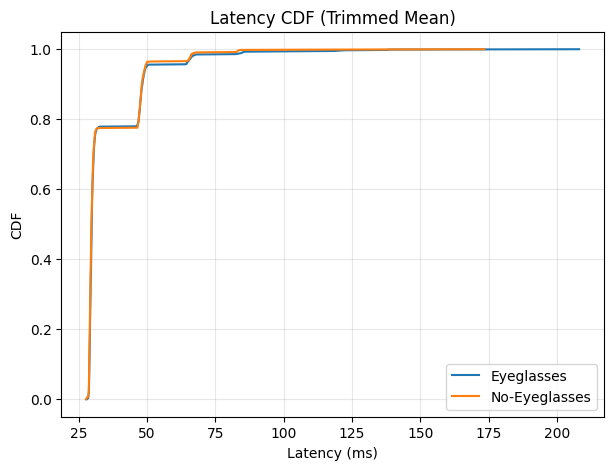

In [66]:
#Make one figure (CDF plot)
import matplotlib.pyplot as plt

def plot_latency_cdf(df_lat, title="Latency CDF (Trimmed Mean)"):
    g = np.sort(df_lat[df_lat["glasses"]==1]["lat_trim_ms"].values)
    n = np.sort(df_lat[df_lat["glasses"]==0]["lat_trim_ms"].values)
    yg = np.linspace(0, 1, len(g), endpoint=True)
    yn = np.linspace(0, 1, len(n), endpoint=True)

    plt.figure(figsize=(7,5))
    plt.plot(g, yg, label="Eyeglasses")
    plt.plot(n, yn, label="No-Eyeglasses")
    plt.xlabel("Latency (ms)")
    plt.ylabel("CDF")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_latency_cdf(df_lat_final)
